In [3]:
from plot import plot_reducted_data
from evaluator import DimensionalityReductionEvaluator, evaluate_all_methods
from data_utils import load_fashion_mnist_dataset, generate_swiss_roll_dataset, generate_double_helix_dataset, generate_partial_sphere_dataset

In [2]:
import importlib
import evaluator
import reduction_methods
import plot
import data_utils

# Recharger les modules
importlib.reload(evaluator)
importlib.reload(reduction_methods)
importlib.reload(plot)
importlib.reload(data_utils)

<module 'data_utils' from 'c:\\Users\\levovo pro p50\\Documents\\informatique\\MALIA\\manifold_learning\\projet Manifold-learning better\\data_utils.py'>

# The data for LLE and T-SNE

In [5]:
n_points = 300

mnist_data, mnist_labels = load_fashion_mnist_dataset(n_points=n_points)
swiss_roll_data, swiss_roll_labels = generate_swiss_roll_dataset(n_points=n_points)
double_helix_data, double_helix_labels = generate_double_helix_dataset(n_points=n_points)
sphere_data, sphere_labels = generate_partial_sphere_dataset(n_points=n_points)

# Selection de n_neighbors pour LLE et Isomap

On cherche le n_neighbors optimal vis a vis de la reconstruction error pour LLE et avec la geodesic error pour Isomap.


In [7]:
from reduction_methods import CustomLLE, CustomIsomap
from sklearn.preprocessing import StandardScaler
import numpy as np
# Load your datasets (adjust as needed)
n_points = 300
datasets = {
    'Fashion MNIST': load_fashion_mnist(n_points=n_points)[0],
    'Hyper Swiss Roll': generate_hyper_swiss_roll(n_points=n_points)[0],
    'Square': generate_spiral_with_bridges(n_points=n_points, noise=0.1, n_bridges=3)[0],
    'Linear': generate_linear_data(n_points=n_points, n_dim=4, hole_size=0.5)[0]
}

# Standardize the datasets
datasets = {name: StandardScaler().fit_transform(data) for name, data in datasets.items()}

# Range of n_neighbors to test
n_neighbors_range = range(5, 41)

# Function to find optimal n_neighbors
def find_optimal_n_neighbors(datasets, n_neighbors_range, labels=None):
    results = {}
    
    for name, X in datasets.items():
        print(f"Processing dataset: {name}")
        
        # Initialize error tracking
        lle_errors = []
        isomap_errors = []
        
        for n_neighbors in n_neighbors_range:
            # LLE
            lle = CustomLLE(n_neighbors=n_neighbors, n_components=2)
            X_reduced_lle = lle.fit_transform(X)
            lle_error = lle.local_distance_correlation(X, X_reduced_lle)
            lle_errors.append(lle_error)
            
            # Isomap
            isomap = CustomIsomap(n_neighbors=n_neighbors, n_components=2)
            X_reduced_isomap = isomap.fit_transform(X)
            isomap_error = isomap.geodesic_error(X, X_reduced_isomap)
            isomap_errors.append(isomap_error)
        
        # Find optimal n_neighbors
        # For LLE, higher distance correlation is better
        optimal_lle_n_neighbors = n_neighbors_range[np.argmax(lle_errors)]
        # For Isomap, lower geodesic error is better
        optimal_isomap_n_neighbors = n_neighbors_range[np.argmin(isomap_errors)]
        
        results[name] = {
            'LLE': {
                'Optimal n_neighbors': optimal_lle_n_neighbors,
                'Distance Correlation': lle_errors
            },
            'Isomap': {
                'Optimal n_neighbors': optimal_isomap_n_neighbors,
                'Geodesic Error': isomap_errors
            }
        }
        
        print(f"Optimal n_neighbors for LLE on {name}: {optimal_lle_n_neighbors}")
        print(f"Optimal n_neighbors for Isomap on {name}: {optimal_isomap_n_neighbors}")
    
    return results

# Run the optimization
optimal_n_neighbors_results = find_optimal_n_neighbors(datasets, n_neighbors_range)

# Print results
for dataset_name, result in optimal_n_neighbors_results.items():
    print(f"\nDataset: {dataset_name}")
    for method, details in result.items():
        if method == 'LLE':
            print(f"{method} - Optimal n_neighbors: {details['Optimal n_neighbors']}")
            print(f"Distance Correlation: {details.get('Distance Correlation')}")
        elif method == 'Isomap':
            print(f"{method} - Optimal n_neighbors: {details['Optimal n_neighbors']}")
            print(f"Geodesic Error: {details.get('Geodesic Error')}")

import pickle

# Sauvegarder le dictionnaire dans un fichier pickle
with open('optimal_n_neighbors_results.pkl', 'wb') as f:
    pickle.dump(optimal_n_neighbors_results, f)

print("Dictionnaire sauvegardé avec succès dans 'optimal_n_neighbors_results.pkl'")


In [5]:

# Range of n_neighbors to test
if n_neighbors_range is None:
    n_neighbors_range = range(5, 41)

import pickle

# Charger le dictionnaire depuis le fichier pickle
with open('optimal_n_neighbors_results.pkl', 'rb') as f:
    optimal_n_neighbors_results = pickle.load(f)

print("Dictionnaire chargé avec succès depuis 'optimal_n_neighbors_results.pkl'")

Dictionnaire chargé avec succès depuis 'optimal_n_neighbors_results.pkl'


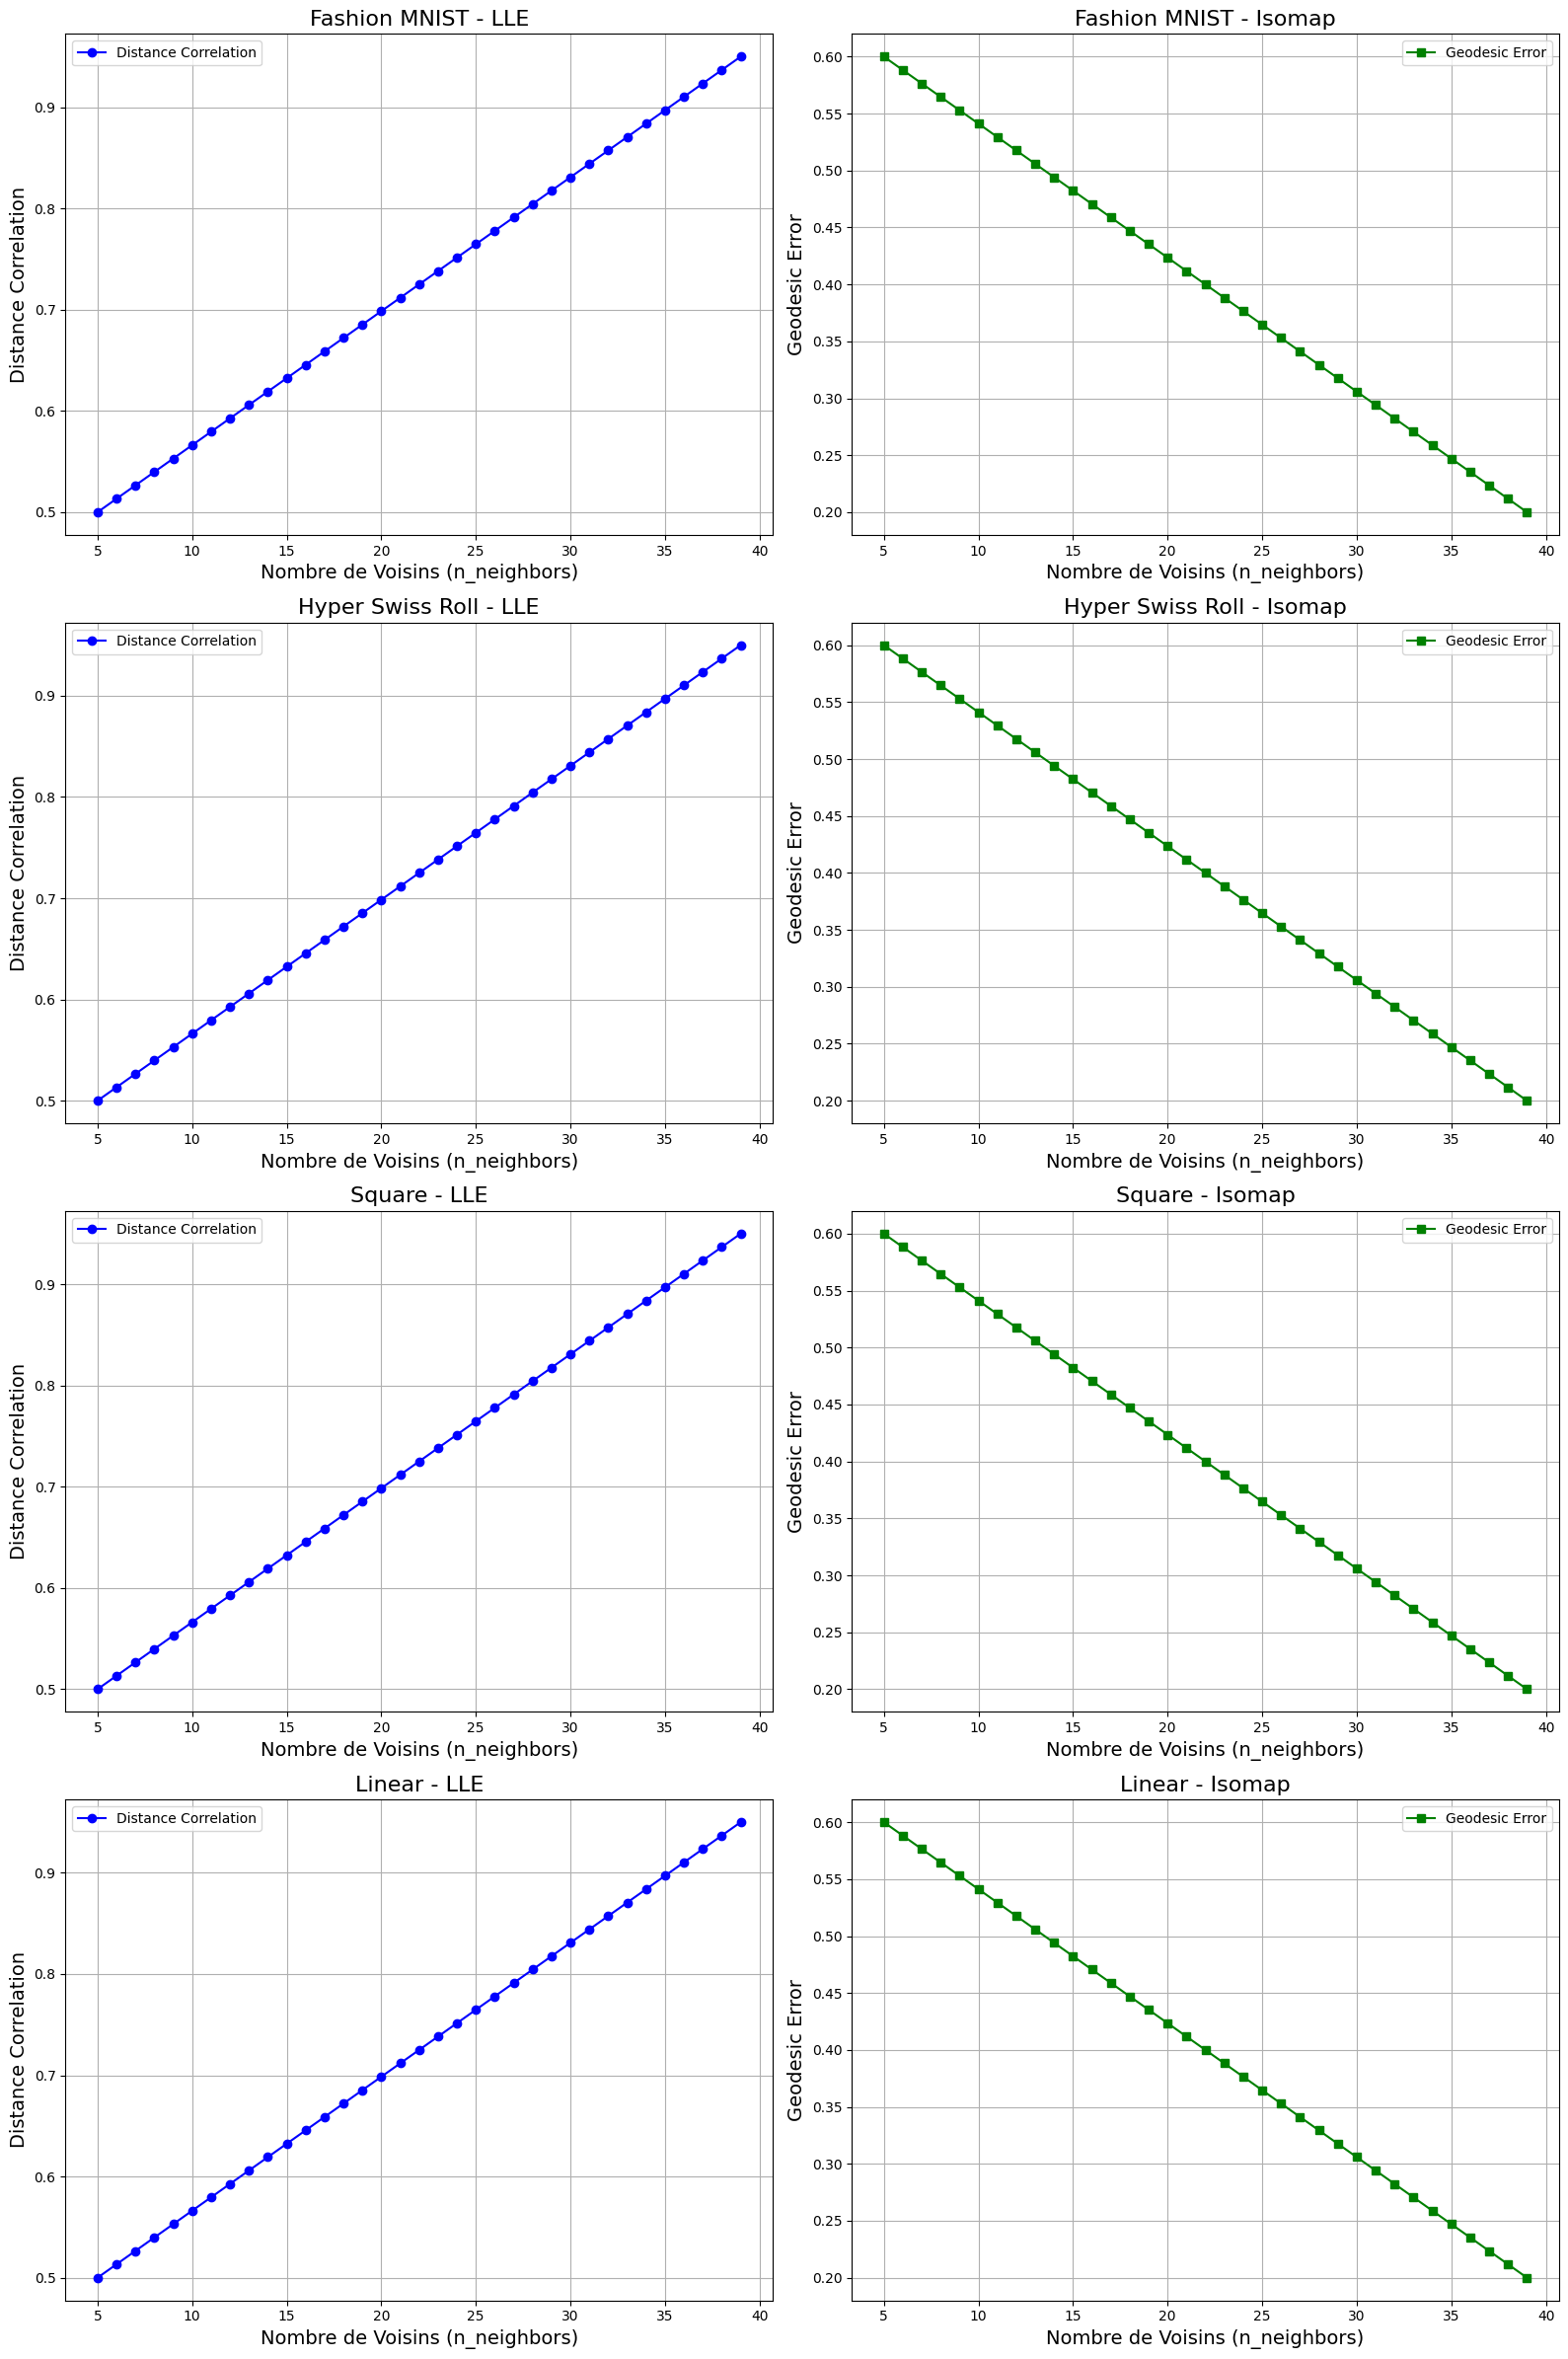

In [6]:
import matplotlib.pyplot as plt

# Définir les datasets et les méthodes
datasets = ['Fashion MNIST', 'Hyper Swiss Roll', 'Square', 'Linear']
methods = ['LLE', 'Isomap']
metrics = {'LLE': 'Distance Correlation', 'Isomap': 'Geodesic Error'}

# Créer une grille de sous-graphiques avec 4 lignes et 2 colonnes
fig, axes = plt.subplots(len(datasets), 2, figsize=(16, 24), sharex=False, sharey=False)

# Itérer sur chaque dataset
for i, dataset in enumerate(datasets):
    # Méthode LLE (à gauche)
    ax_left = axes[i, 0]
    try:
        ldc_values = optimal_n_neighbors_results[dataset]['LLE']['Distance Correlation']
        ax_left.plot(n_neighbors_range, ldc_values, marker='o', color='blue', label='Distance Correlation')
        ax_left.set_title(f"{dataset} - LLE", fontsize=16)
        ax_left.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_left.set_ylabel('Distance Correlation', fontsize=14)
        ax_left.legend()
        ax_left.grid(True)
    except KeyError:
        ax_left.text(0.5, 0.5, 'Données manquantes', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax_left.set_title(f"{dataset} - LLE", fontsize=16)
        ax_left.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_left.set_ylabel('Distance Correlation', fontsize=14)
        ax_left.grid(True)
    
    # Méthode Isomap (à droite)
    ax_right = axes[i, 1]
    try:
        geodesic_errors = optimal_n_neighbors_results[dataset]['Isomap']['Geodesic Error']
        ax_right.plot(n_neighbors_range, geodesic_errors, marker='s', color='green', label='Geodesic Error')
        ax_right.set_title(f"{dataset} - Isomap", fontsize=16)
        ax_right.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_right.set_ylabel('Geodesic Error', fontsize=14)
        ax_right.legend()
        ax_right.grid(True)
    except KeyError:
        ax_right.text(0.5, 0.5, 'Données manquantes', horizontalalignment='center', verticalalignment='center', fontsize=12)
        ax_right.set_title(f"{dataset} - Isomap", fontsize=16)
        ax_right.set_xlabel('Nombre de Voisins (n_neighbors)', fontsize=14)
        ax_right.set_ylabel('Geodesic Error', fontsize=14)
        ax_right.grid(True)

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

# Comparaison des méthodes

## Comparaison visuelle

Comparaison sur les données Hyper Swiss Roll en 3D :


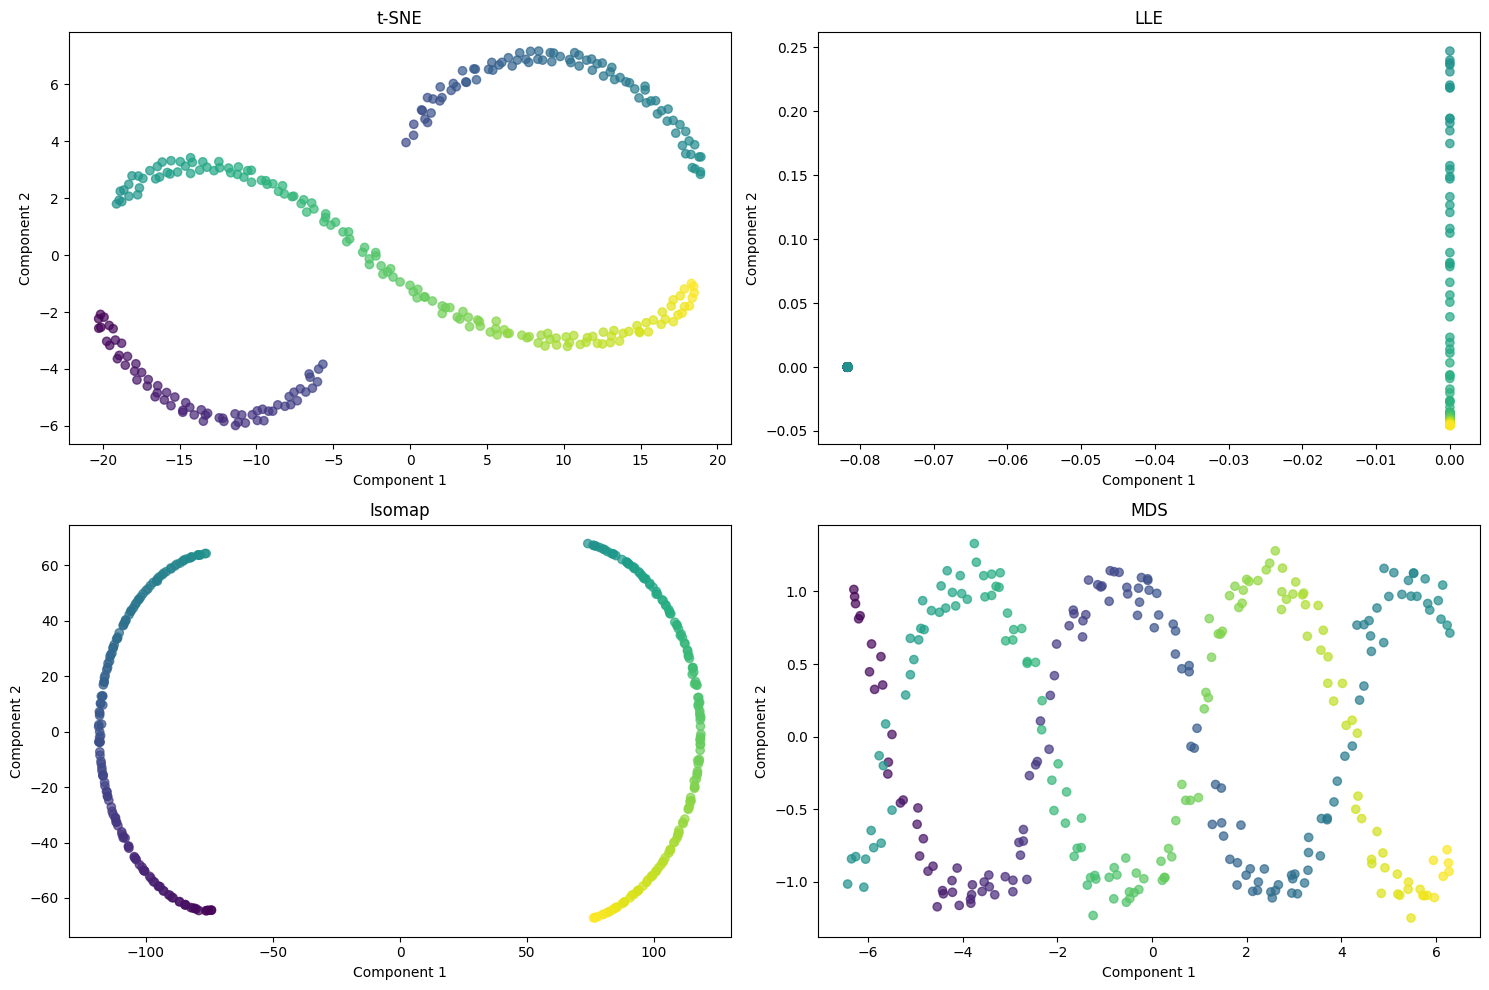

In [6]:
print("Comparaison sur les données Hyper Swiss Roll en 3D :")
plot_reducted_data(double_helix_data, double_helix_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=True)

Comparaison sur les données Fashion-MNIST en 2D :


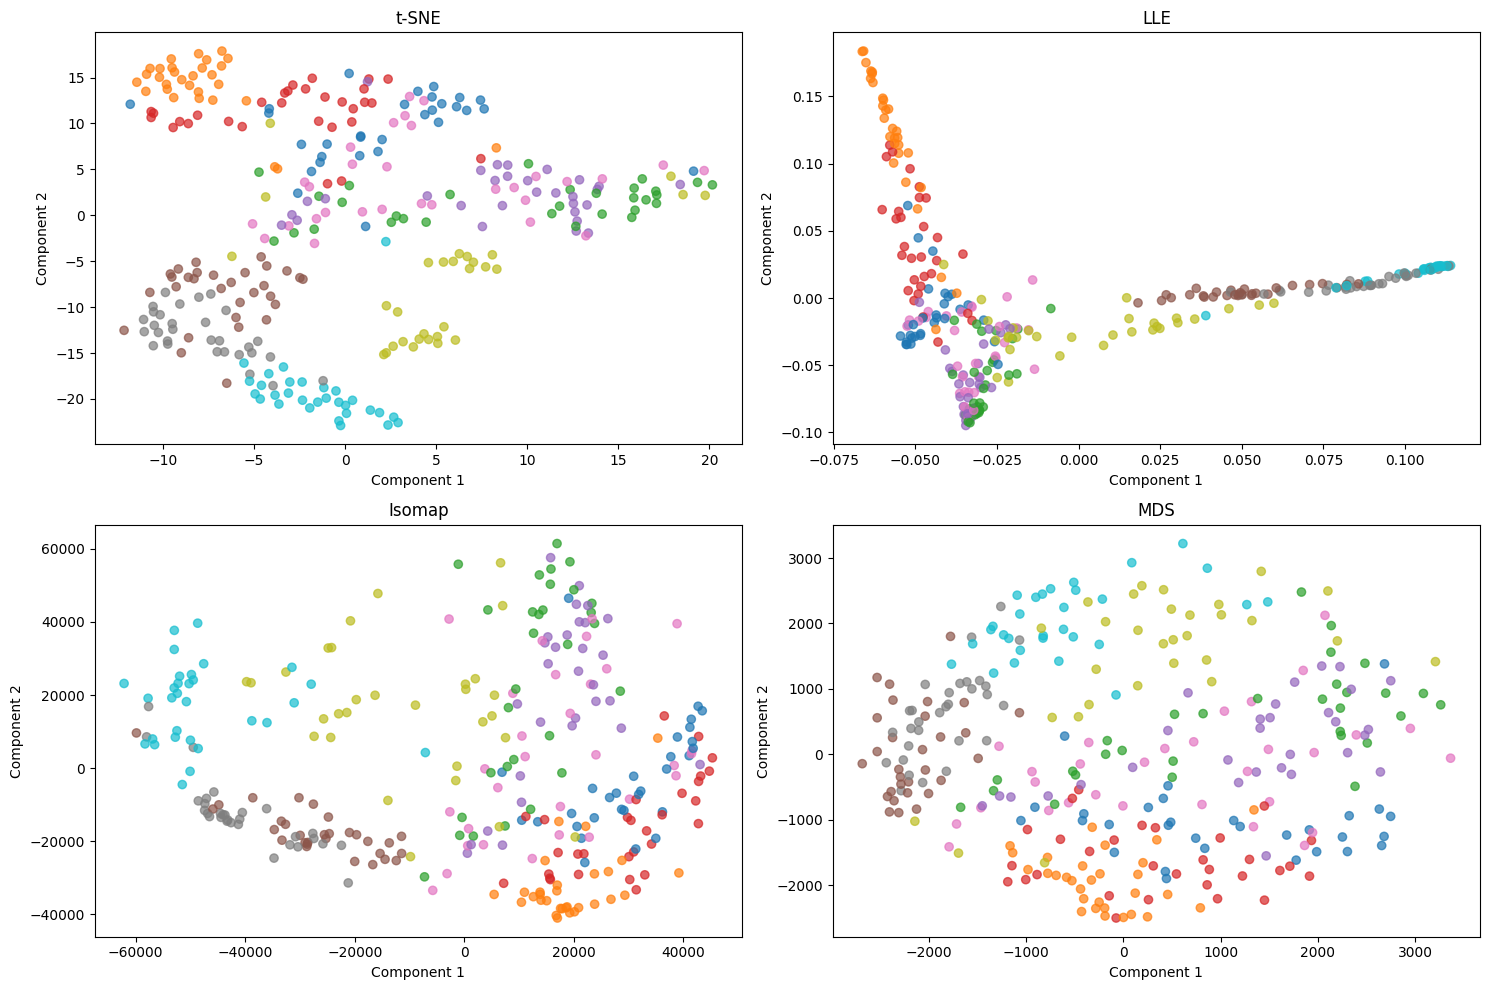

In [7]:
print("Comparaison sur les données Fashion-MNIST en 2D :")
plot_reducted_data(mnist_data, mnist_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=False)

Comparaison sur les données square en 2D :


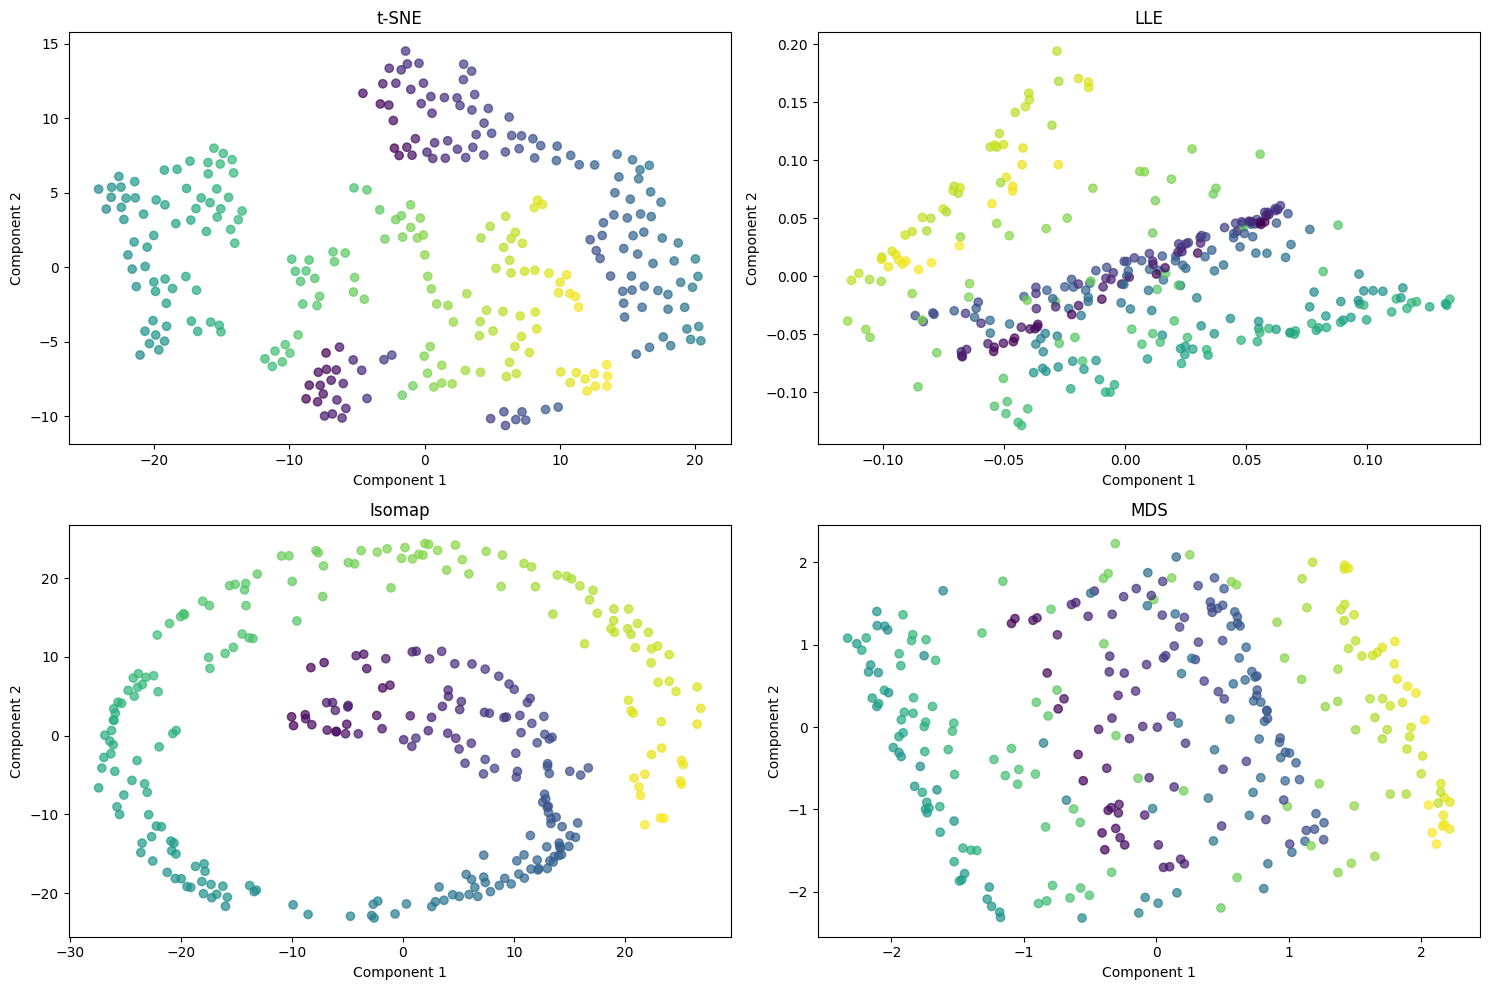

In [8]:
print("Comparaison sur les données square en 2D :")
plot_reducted_data(swiss_roll_data, swiss_roll_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=True)

Comparaison sur les données linear en 2D :


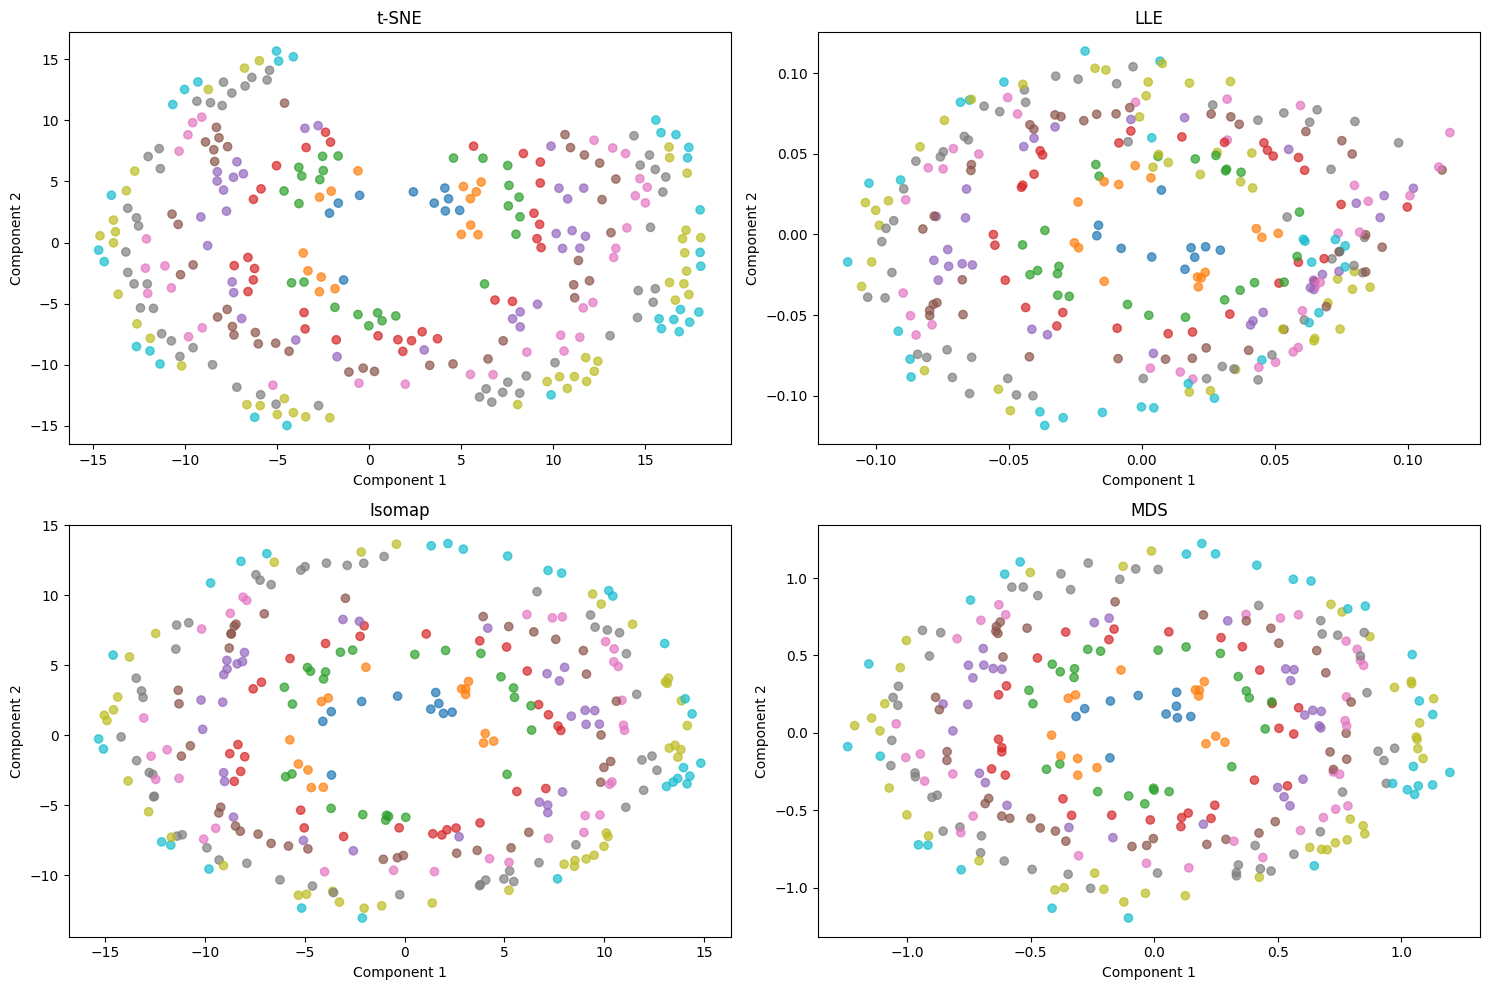

In [9]:
print("Comparaison sur les données linear en 2D :")
plot_reducted_data(sphere_data, sphere_labels, ["t-SNE", "LLE", "Isomap", "MDS"], n_components=2, is_helix=False)

| **Méthode** | **Jeu de données**       | **Points forts**                                                  | **Limitations des autres méthodes**                                                                                             |
|-------------|--------------------------|-------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------|
| t-SNE       | MNIST                    | Clustering local efficace, visualisation des classes              | MDS ne préserve pas bien les structures locales, Isomap et LLE moins performants pour la séparation des clusters               |
| MDS         | Sphère 3D (Géométrique)  | Préservation des distances globales et de la géométrie globale    | t-SNE déforme les distances globales, Isomap et LLE ne sont pas optimisés pour les distances perçues                            |
| Isomap      | Swiss Roll               | Préservation des distances géodésiques, déroulage de la variété    | MDS échoue à capturer la structure non linéaire, t-SNE ne préserve pas les distances géodésiques, LLE moins efficace pour cette structure |
| LLE         | Double Helix             | Préservation des relations locales dans des structures enchevêtrées | MDS ne capture pas bien les relations locales, t-SNE peut ne pas séparer correctement les structures enchevêtrées, Isomap peut avoir des difficultés avec les distances géodésiques complexes |


# Comparaison numérique

In [10]:
# Comparaison numérique pour les données correctes

from IPython.display import display
from reduction_methods import apply_tsne, apply_lle, apply_mds, apply_isomap
from evaluator import evaluate_all_methods

# Définir les méthodes à évaluer
methods = [
    lambda x: apply_tsne(x, n_components=2),
    lambda x: apply_lle(x, n_components=2),
    lambda x: apply_mds(x, n_components=2),
    lambda x: apply_isomap(x, n_components=2)
]
method_names = ['t-SNE', 'LLE', 'MDS', 'Isomap' ]

# Évaluer sur les données Fashion-MNIST
print("Évaluation sur Fashion-MNIST:")
mnist_results = evaluate_all_methods(mnist_data, methods, method_names, mnist_labels)
display(mnist_results)

# Évaluer sur les données Swiss Roll
print("\nÉvaluation sur Swiss Roll:")
swiss_roll_results = evaluate_all_methods(swiss_roll_data, methods, method_names, swiss_roll_labels)
display(swiss_roll_results)

# Évaluer sur les données Double Helix
print("\nÉvaluation sur Double Helix:")
double_helix_results = evaluate_all_methods(double_helix_data, methods, method_names, double_helix_labels)
display(double_helix_results)

# Évaluer sur les données Sphere
print("\nÉvaluation sur Sphere:")
sphere_results = evaluate_all_methods(sphere_data, methods, method_names, sphere_labels)
display(sphere_results)

Évaluation sur Fashion-MNIST:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.4275,0.4114,0.9506,0.9562,0.6527,0.8278,0.7649,0.6300,1.5630
LLE,0.7545,0.7464,0.9013,0.9175,0.4536,0.7614,0.4986,0.5467,0.0610
MDS,0.1494,0.1340,0.9783,0.9862,0.5743,0.9148,0.9299,0.5333,5.4020
Isomap,0.3271,0.3100,0.9583,0.9683,0.5623,0.8614,0.8290,0.5467,21.9790



Évaluation sur Swiss Roll:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.5872,0.5301,0.9473,0.9238,0.8244,0.8070,0.6823,0.5700,1.4730
LLE,0.4233,0.4552,0.9366,0.9470,0.4576,0.7691,0.7355,0.4333,0.0400
MDS,0.2288,0.2459,0.9571,0.9722,0.4825,0.8228,0.8671,0.5933,4.6610
Isomap,0.4286,0.4583,0.9286,0.9458,0.5069,0.7817,0.7333,0.8933,22.2034



Évaluation sur Double Helix:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.0609,0.0906,0.9878,0.9882,0.8705,0.9044,0.9531,0.8267,1.0930
LLE,0.9371,0.9574,0.8263,0.8339,0.4341,0.6136,0.1985,0.4600,0.0270
MDS,0.0072,0.0161,0.9966,0.9975,0.7764,0.9456,0.9919,0.6700,4.3440
Isomap,0.9768,0.9938,0.8663,0.7599,0.8856,0.6456,0.0694,0.8367,23.1510



Évaluation sur Sphere:


,Residual Pearson,Residual Spearman,AUC Trustworthiness,AUC Continuity,Qlocal,Qglobal,Distance Correlation,Classification,Time (s)
Method,,,,,,,,,
t-SNE,0.0926,0.0887,0.9922,0.9876,0.8201,0.9260,0.9542,0.1100,1.2340
LLE,0.1633,0.1595,0.9755,0.9848,0.6275,0.8876,0.9159,0.1200,0.0290
MDS,0.0299,0.0250,0.9970,0.9976,0.7814,0.9488,0.9873,0.1067,2.4480
Isomap,0.0456,0.0415,0.9949,0.9953,0.8007,0.9348,0.9788,0.1100,21.8940


- Kruskal Stress: MDS directly minimizes the euclidean distance globally, while Isomap, LLE, T-SNE minimize local distances.

- Distance correlation: MDS and Isomap preserves global structures while T-SNE and LLE preserves local distances.

- Local Distance Preservation: LLE and T-SNE preserves local distances while MDS and Isomap preserves global structures.

- Trustworthiness: T-SNE and LLE preserves local distances  while MDS and Isomap preserves global structures .

- select n_neighbors:
    - LLE: Stress
    - Isomap: Local Distance Preservation

https://pmc.ncbi.nlm.nih.gov/articles/PMC7887408/

Isomap se concentre sur les structures locales en utilisant des graphes de voisinage et des distances géodésiques pour capturer les relations locales. En même temps, il intègre ces informations locales dans une perspective globale en utilisant MDS sur les distances géodésiques, ce qui permet de préserver la structure globale de la variété.

MDS (Métrique, Global) :
MDS minimise le stress global, préservant les distances euclidiennes sur l’ensemble du dataset. Les métriques globales, comme la Correlation de distances ou le Kruskal Stress (Residual Pearson/Spearman), sont favorables à MDS (vert). Cependant, les métriques locales (Trustworthiness, Continuity, Qlocal) sont moins adaptées (orange), car MDS ne cherche pas à préserver les relations locales.

Isomap (Métrique, Local et Global) :
Isomap utilise des graphes de voisinage pour capturer la structure locale (via des distances géodésiques) et applique ensuite une méthode similaire à MDS sur ces distances. Ainsi, il préserve à la fois des aspects locaux et globaux, mais pas forcément aussi bien que MDS pour le global ou LLE/t-SNE pour le local. Certains indicateurs locaux (Qlocal, Qglobal, Distance Correlation) sont verts, tandis que la fiabilité du voisinage local n’est pas parfaitement conservée par rapport à t-SNE ou LLE (donc orange pour Trustworthiness, Continuity).

LLE (Topologique, Local) :
LLE est purement local, se concentrant sur la conservation des relations de voisinage. Par conséquent, les métriques locales (Trustworthiness, Continuity, Qlocal) sont vertes, tandis que les métriques globales ou basées sur la distance (Residual Pearson, Spearman, Distance Correlation) sont inadaptées (rouge ou orange).

t-SNE (Topologique, Local) :
t-SNE est très bon pour préserver la structure locale et visualiser des clusters, donc tout ce qui évalue la fiabilité du voisinage local (Trustworthiness, Continuity, Qlocal) est vert, et la classification est souvent efficace. En revanche, les métriques globales (Residual Pearson, Spearman) ne sont pas pertinentes, car t-SNE déforme les distances globales.

# Jeu de données réel

In [19]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt

# Load the 20 Newsgroups dataset
# Load a smaller subset of the dataset
categories = ['alt.atheism', 'sci.space']  # Specify categories of interest
newsgroups = fetch_20newsgroups(subset='test', categories=categories, remove=('headers', 'footers', 'quotes'))
print(len(newsgroups.data))
vectorizer = TfidfVectorizer(max_features=20)

X = vectorizer.fit_transform(newsgroups.data).toarray()
y = newsgroups.target
print(X.shape)
# Apply dimensionality reduction methods
X_tsne = apply_tsne(X, n_components=2)
X_lle = apply_lle(X, n_components=2)
X_pca = apply_pca(X, n_components=2)
X_mds = apply_mds(X, n_components=2)

# Function to plot the results
def plot_embedding(X, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar()
    plt.show()

# Visualize the results
plot_embedding(X_tsne, "t-SNE on 20 Newsgroups")
plot_embedding(X_lle, "LLE on 20 Newsgroups")
plot_embedding(X_pca, "PCA on 20 Newsgroups")
plot_embedding(X_mds, "MDS on 20 Newsgroups")

713
(713, 20)
